In [1]:
import math
from array import array
from collections import deque
from operator import itemgetter
from typing import NamedTuple, TypedDict

import gym
import gymnasium
import matplotlib.pyplot as plt
import numpy as np
import stable_baselines3 as sb3

/home/qbok/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
class F110Observation(TypedDict):
    ego_idx: int
    scans: list[array]
    poses_x: list[float]
    poses_y: list[float]
    poses_theta: list[float]
    linear_vels_x: list[float]
    linear_vels_y: list[float]
    ang_vels_z: list[float]
    collisions: array
    lap_times: array
    lap_counts: array

In [3]:
class F110EnvParams(NamedTuple):
    vmin: float
    vmax: float
    smin: float
    smax: float

In [4]:
def rescale(value: np.ndarray, fr: tuple[float, float], to: tuple[float, float]) -> np.ndarray:
    frrange, torange = fr[1] - fr[0], to[1] - to[0]
    return (((value - fr[0]) * torange) / frrange) + to[0]

In [5]:
class F110Wrapped(gymnasium.Wrapper):
    def __init__(self, env: gym.Env, waypoints: np.ndarray):
        super().__init__(env)

        self._params = F110EnvParams(
            *itemgetter("v_min", "v_max", "s_min", "s_max")(env.params)
        )

        # self.action_space = gymnasium.spaces.Box(
        #     low=np.array([params.vmin, params.smin]),
        #     high=np.array([params.vmax, params.smax]),
        #     dtype=float,
        # )

        self.action_space = gymnasium.spaces.Box(
            low=np.array([-1.0, -1.0]),
            high=np.array([1.0, 1.0]),
            dtype=float,
        )

        self.observation_space = gymnasium.spaces.Box(
            low=-1.0, high=1.0, shape=(1080,), dtype=float
        )

        self._point = 0
        self._waypoints = waypoints


    def step(self, action: np.ndarray) -> tuple[np.ndarray, float, bool, bool, dict]:
        velocity = rescale(action[0], (self._params.vmin, self._params.vmax), (-1.0, 1.0))
        angle = rescale(action[1], (self._params.smin, self._params.smax), (-1.0, 1.0))

        obs, reward, done, info = self.env.step(np.array([[velocity, angle]]))
        obs: F110Observation
        trunc = False

        # reward = 0.0
        # prioritize velocity
        velocity = math.hypot(obs["linear_vels_x"][0], obs["linear_vels_y"][0])
        reward = max(np.log(velocity) * self.env.timestep, -1.0)

        x, y = obs["poses_x"][0], obs["poses_y"][0]
        wx, wy = self._waypoints[self._point][:2]
        dist = np.hypot(x - wx, y - wy)

        if dist < 2.0:
            self._point += 1
            reward += self._point / len(self._waypoints)

        if self._point >= len(self._waypoints):
            self._point = 0

        # if (vang := abs(obs["ang_vels_z"][0])) > 0.4:
        #     reward -= vang

        if abs(obs["poses_theta"][0]) > math.pi / 6:
            reward, done = -2.5, True

        if obs["collisions"][0]:
            reward, done = -1.0, True

        return (
            rescale(obs["scans"][0], (0.0, 30.0), (-1.0, 1.0)),
            reward,
            done,
            trunc,
            {**info, **obs},
        )

    def reset(self, seed=None) -> tuple[np.ndarray, dict]:
        obs, info = self.env.reset(poses=np.array([[0.0, 0.0, 0.0]]))[::3]
        self._point = 0
        return obs["scans"][0], info

In [6]:
waypoints = np.genfromtxt('spielberg-waypoints.csv', delimiter=',')
waypoints.shape

(864, 4)

In [7]:
env = gym.make(
    "f110_gym:f110-v0",
    map="../../f1tenth_gym_ros/maps/spielberg",
    map_ext=".png",
    num_agents=1,
)
env

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/qbok/rossim/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


In [8]:
wrapped = F110Wrapped(env, waypoints)

In [9]:
model = sb3.PPO(
    "MlpPolicy",
    wrapped,
    # tensorboard_log="logs",
    learning_rate=0.001
)

/home/qbok/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/home/qbok/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [10]:
model.learn(20000)

In [11]:
model.save("f110-model.zip")

In [12]:
obs, states = wrapped.reset()
rewards = []
obss = []

for i in range(250):
    action, info = model.predict(obs)
    obs, rew, done, trunc, info = wrapped.step([1.0, 0.0])

    if done or trunc:
        obs, states = wrapped.reset()

    data = tuple(
        map(
            itemgetter(0),
            itemgetter(
                "poses_x",
                "poses_y",
                "poses_theta",
                "linear_vels_x",
                "linear_vels_y",
                "ang_vels_z",
            )(info),
        )
    )

    obss.append(data)
    rewards.append(rew)

/tmp/ipykernel_1462/2283742412.py:40: RuntimeWarning: divide by zero encountered in log
  reward = max(np.log(velocity) * self.env.timestep, -1.0)
/tmp/ipykernel_1462/2283742412.py:40: RuntimeWarning: divide by zero encountered in log
  reward = max(np.log(velocity) * self.env.timestep, -1.0)


In [13]:
import pandas as pd

COLS = [
    "X",
    "Y",
    "TH",
    "VX",
    "VY",
    "VZ",
]

<Axes: >

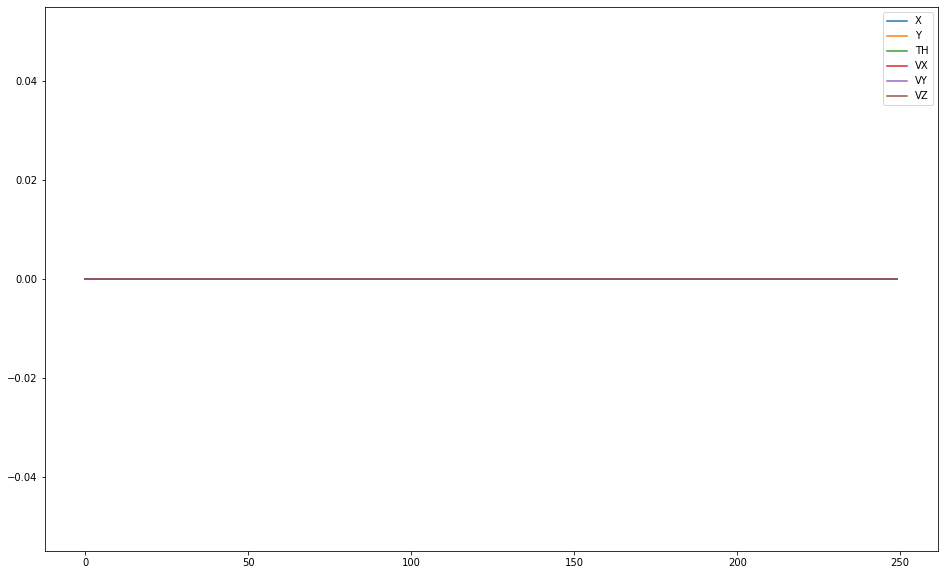

In [14]:
pd.DataFrame(obss, columns=COLS).plot(figsize=(16, 10))

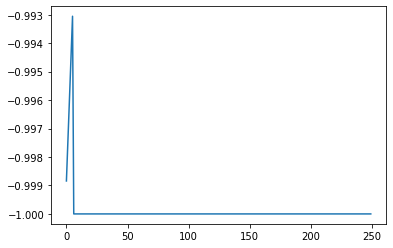

In [15]:
plt.plot(rewards)